In [346]:
import numpy as np
#np.set_printoptions(threshold=np.inf) #For diagnostic printing of an entire array.
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline as us
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import csv

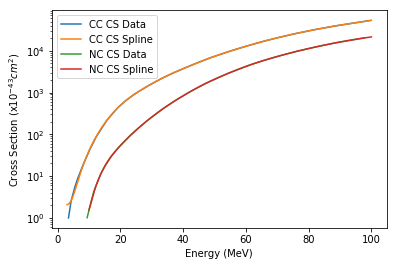

In [524]:
DUNE_FIDUCIAL_MASS = 10.643e9 #g
ARGON_MASS = 6.6335209e-23 #g

nu_Ar40_NC_cross_section_data_cs = []
nu_Ar40_NC_cross_section_data_energy = []
nu_e_Ar40_CC_cross_section_data_cs = []
nu_e_Ar40_CC_cross_section_data_energy = []

#Read in data digitized from arXiv:hep-ph/0307244v2
with open('/Users/brent/Desktop/Grad School/Experimental Methods/Nu Ar40 NC cross section.csv', newline='') as data:
    data_reader = csv.reader(data, delimiter=',')
    for row in data_reader:
        nu_Ar40_NC_cross_section_data_energy.append(float(row[0])) # MeV
        nu_Ar40_NC_cross_section_data_cs.append(float(row[1])) # x10^-43 cm^2

with open('/Users/brent/Desktop/Grad School/Experimental Methods/Nu_e Ar40 CC cross section.csv', newline='') as data:
    data_reader = csv.reader(data, delimiter=',')
    for row in data_reader:
        nu_e_Ar40_CC_cross_section_data_energy.append(float(row[0])) # MeV
        nu_e_Ar40_CC_cross_section_data_cs.append(float(row[1])) # x10^-43 cm^2
        
nu_Ar40_NC_cross_section_data_cs = np.sort(np.asarray(nu_Ar40_NC_cross_section_data_cs))
nu_Ar40_NC_cross_section_data_energy = np.sort(np.asarray(nu_Ar40_NC_cross_section_data_energy))
nu_e_Ar40_CC_cross_section_data_cs = np.sort(np.asarray(nu_e_Ar40_CC_cross_section_data_cs))
nu_e_Ar40_CC_cross_section_data_energy = np.sort(np.asarray(nu_e_Ar40_CC_cross_section_data_energy))

#Create univariate spline to interpolate across cross section data and fill in missing data points.
cc_spl = us(nu_e_Ar40_CC_cross_section_data_energy, nu_e_Ar40_CC_cross_section_data_cs)
nc_spl = us(nu_Ar40_NC_cross_section_data_energy, nu_Ar40_NC_cross_section_data_cs)

#Plot these to make sure they worked well.
test_energy = np.linspace(3, 100, 10000)
plt.plot(nu_e_Ar40_CC_cross_section_data_energy, (nu_e_Ar40_CC_cross_section_data_cs), label="CC CS Data")
plt.plot(test_energy, (cc_spl(test_energy)), label="CC CS Spline")

test_energy = np.linspace(10,100,10000)
plt.plot(nu_Ar40_NC_cross_section_data_energy, (nu_Ar40_NC_cross_section_data_cs), label="NC CS Data")
plt.plot(test_energy, (nc_spl(test_energy)), label="NC CS Spline")

plt.semilogy()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross Section (x$10^{-43}$$cm^{2}$)")
plt.legend()
plt.savefig('cross_section.png')
plt.show()

3.120755e+58
3.086e+22


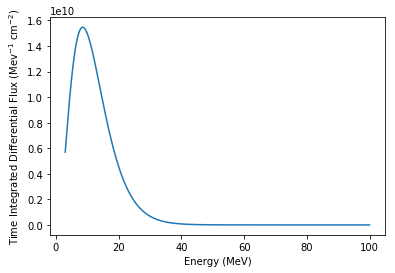

In [529]:
def dPhidE_nu(E_nu, E_SN, d, avg_E_nu):
    return(E_SN * E_nu ** 2.5 * np.exp(-3.5 * E_nu / avg_E_nu) / (4 * np.pi * d ** 2 * (avg_E_nu / 3.5) ** 4.5 * 11.6317))

def erg_to_MeV(ergs):
    return(6.24151e5 * ergs)

def kpc_to_cm(kpcs):
    return(3.086e21 * kpcs)

test_E_SN_e = erg_to_MeV(0.5e53)
print(test_E_SN_e)
test_d = kpc_to_cm(10.)
print(test_d)
test_avg_E_nu_e = 12.
test_E_nu_e = np.linspace(3,100,10000)

plt.plot((test_E_nu_e), (dPhidE_nu(test_E_nu_e, test_E_SN_e, test_d, test_avg_E_nu_e)))
plt.xlabel("Energy (MeV)")
plt.ylabel("Time Integrated Differential Flux (Mev$^{-1}$ cm$^{-2}$)")
#plt.savefig('fluence.png')
plt.show()

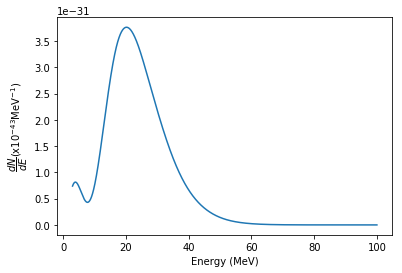

1265.6047306683788


In [531]:
plt.plot(test_E_nu_e, (dPhidE_nu(test_E_nu_e, test_E_SN_e, test_d, test_avg_E_nu_e) * (cc_spl(test_E_nu_e) + nc_spl(test_E_nu_e)) + 5 * dPhidE_nu(test_E_nu_e, test_E_SN_e, test_d, test_avg_E_nu_e) * nc_spl(test_E_nu_e)) * 1e-43)
plt.xlabel("Energy (MeV)")
plt.ylabel(r'$\dfrac{dN}{dE}$'+'(x'+r'$10^{-43}$'+'MeV'+r'$^{-1}$)')
plt.savefig("dNdE.png")
plt.show()

#Probability of a supernova neutrino distributed along the energy spectrum interacting within the DUNE detector
prob = quad(lambda test_E_nu_e: (dPhidE_nu(test_E_nu_e, test_E_SN_e, test_d, test_avg_E_nu_e) * (cc_spl(test_E_nu_e) + nc_spl(test_E_nu_e)) + 5 * dPhidE_nu(test_E_nu_e, test_E_SN_e, test_d, test_avg_E_nu_e) * nc_spl(test_E_nu_e)) * 1e-43, 3, 100)

#Number of interactions in the DUNE Fiducial Volume
N = prob[0] * DUNE_FIDUCIAL_MASS / ARGON_MASS
print(N)


In [532]:
nu_number = np.random.poisson(N, 10)
print(nu_number)

[1304 1230 1284 1251 1294 1233 1199 1253 1244 1317]


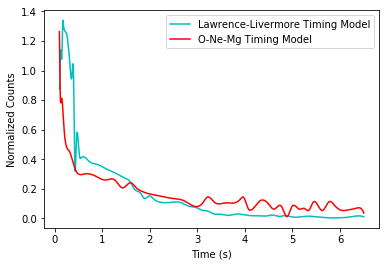

In [535]:
#Here we are going to take the digitized SN neutrino timing models from arXiv:1108.0171v2 (IceCube SN paper)
lawr_liv_time_model_counts = []
lawr_liv_time_model_time = []
ONeMg_time_model_counts = []
ONeMg_time_model_time = []

with open("/Users/brent/Desktop/Grad School/Experimental Methods/Lawrence Livermore Model IceCube.csv", newline='') as data:
    data_reader = csv.reader(data, delimiter=',')
    for row in data_reader:
        lawr_liv_time_model_time.append(float(row[0]))
        lawr_liv_time_model_counts.append(float(row[1]))

with open("/Users/brent/Desktop/Grad School/Experimental Methods/ONeMg1D Model _IceCube_.csv", newline='') as data:
    data_reader = csv.reader(data, delimiter=',')
    for row in data_reader:
        ONeMg_time_model_time.append(float(row[0]))
        ONeMg_time_model_counts.append(float(row[1]))

lawr_liv_time_model_counts = np.asarray(lawr_liv_time_model_counts)
lawr_liv_time_model_time = np.asarray(lawr_liv_time_model_time)
ONeMg_time_model_counts = np.asarray(ONeMg_time_model_counts)
ONeMg_time_model_time = np.asarray(ONeMg_time_model_time)

#Roughly chop off the IceCube background counts. Need to leave all data points taken above 0, which means this is
#definitely rough at best. Statistical fluctuations of the predicted IceCube background are taken into account here,
#which is almost certainly not intrinsic to the model as it would be applied to DUNE. The thinking is that the basic
#shapes should be close enough to give a clear idea of how well DUNE distinguishes the black hole remnant from a NS.
lawr_liv_time_model_counts -= 67500.
ONeMg_time_model_counts -= 65250.

#Create a spline of the data so that we can use the model.
lawr_liv_spl = us(lawr_liv_time_model_time, lawr_liv_time_model_counts, k=2)
ONeMg_time_spl = us(ONeMg_time_model_time, ONeMg_time_model_counts, k=3)

time = np.linspace(0.1, 6.5, 10000)

#Integrate over the model so that we can normalize it into a pdf.
ll_norm = quad(lambda x: lawr_liv_spl(x), 0.1, 6.5, limit=100, epsabs=1.0e-7, epsrel=1.0e-5)
onm_norm = quad(lambda x: ONeMg_time_spl(x), 0.1, 6.5, limit=100, epsabs=1.0e-7, epsrel=1.0e-5)

#Normalize.
temp1 = np.asarray(lawr_liv_time_model_counts / ll_norm[0])
temp2 = np.asarray(ONeMg_time_model_counts / onm_norm[0])

#Create a new spline that uses the normalized flux.
lawr_liv_spl = us(lawr_liv_time_model_time, temp1, k=3, s=0)
ONeMg_time_spl = us(ONeMg_time_model_time, temp2, k=3, s=0)

plt.plot(time, lawr_liv_spl(time), 'c', label="Lawrence-Livermore Timing Model")
plt.plot(time, ONeMg_time_spl(time), 'r', label="O-Ne-Mg Timing Model")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Counts")
plt.legend()
plt.savefig('timing_model.png')
plt.show()
#plt.plot(lawr_liv_time_model_time, lawr_liv_time_model_counts / ll_norm[0] - 0.147, 'co')
#plt.plot(ONeMg_time_model_time, ONeMg_time_model_counts / onm_norm[0] - 0.154, 'ro')

2175


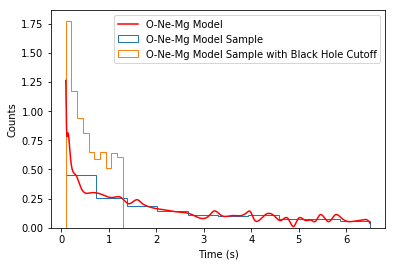

949


In [538]:
#Use np.random.choice to create a sizable numpy array for the model, then sample the number of events from it.
ll_sample = np.random.choice(time, size=2175, p=lawr_liv_spl(time)/np.sum(lawr_liv_spl(time)))
onm_sample = np.random.choice(time, size=2175, p=ONeMg_time_spl(time)/np.sum(ONeMg_time_spl(time)))

#plt.hist(ll_sample, bins=30, density=True, histtype='step', label="Lawrence-Livermore Model Sample")
plt.hist(onm_sample, bins=10, density=True, histtype='step', label="O-Ne-Mg Model Sample")
#plt.plot(time, lawr_liv_spl(time), 'c', label="Lawrence-Livermore Model")
plt.plot(time, ONeMg_time_spl(time), 'r', label="O-Ne-Mg Model")
print(len(ll_sample))

bl_hole_ll_test = []
for i in onm_sample:
    if i < 1.3:
        bl_hole_ll_test.append(i)

bl_hole_ll_test = np.asarray(bl_hole_ll_test)
plt.hist(bl_hole_ll_test, bins=10, density=True, histtype='step', label="O-Ne-Mg Model Sample with Black Hole Cutoff")
plt.xlabel("Time (s)")
plt.ylabel("Counts")
plt.legend()
#plt.savefig('ll_samples.png')
plt.savefig('onm_samples.png')
plt.show()
print(len(bl_hole_ll_test))
#print(bl_hole_ll_test)

In [521]:
print(stats.ks_2samp(onm_sample, np.random.choice(time, size=int(1e6), p=ONeMg_time_spl(time)/np.sum(ONeMg_time_spl(time)))))
print(stats.ks_2samp(bl_hole_ll_test, np.random.choice(time, size=int(1e6), p=ONeMg_time_spl(time)/np.sum(ONeMg_time_spl(time)))))
print(stats.ks_2samp(bl_hole_ll_test, onm_sample))


Ks_2sampResult(statistic=0.022582045977011467, pvalue=0.21583930881135802)
Ks_2sampResult(statistic=0.575019, pvalue=3.1482073731011944e-260)
Ks_2sampResult(statistic=0.5871264367816091, pvalue=1.299241414316124e-192)
